In [3]:
import numpy as np
import scipy
import pickle
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy.ndimage.filters import gaussian_filter1d as gf1d
import datetime
import plot_clouds

plt.rcParams['figure.figsize'] = [20,10]
plt.rcParams['figure.dpi'] = 50
plt.rcParams['savefig.dpi'] = 256

plt.rcParams['font.size'] = 30
plt.rcParams['legend.fontsize'] = 'large'

In [19]:
Save_Files = False
Save_Figures = False

# Set tile width you want to use
tile_width = 8

# Set today's date
Date = np.datetime_as_string(np.datetime64('today'))
# Set experiment number (if you're running numerous different experiments in a given day)
exp_num = '_exp01'
# creates file_ID
file_ID = Date+exp_num+'_TW%s'%(tile_width)
# Import color scheme
Colors = plot_clouds.Colors()

# Find all cloud cycles within both sets

In [42]:
# Import Tile width data set
nc_H = Dataset('./NC_files/Lund_LES_CWP_0p0_Tiles.nc')
# Import dimensions
nt,nx,ny = nc_H.variables['Tile Width %s'%(tile_width)].shape
# Define H_all
Index = np.arange(0,nx,tile_width)
H_all = nc_H.variables['Tile Width %s'%(tile_width)][:,Index,Index]
# define the number of tiles horizontal tiles
nTiles = nx//tile_width

In [37]:
# plot signal
#for kk in range(nTiles):
#    for jj in range(nTiles):
#        plt.plot(H_all[:,kk,jj])
#        plt.show()

In [43]:
lower_thresh = 500 # cloud must start below this depth
upper_thresh = 500 # cloud must grow above this depth
sigma = 10         # standard deviation of Gaussian filter for temporal smoother

Start_cycles = [int(4.5*60),int(7.5*60)]
End_cycles = [int(8*60),int(12*60)]

XYT = []
for ii in range(len(Start_cycles)):
    for kk in range(nTiles):
        for jj in range(nTiles):
            H = gf1d(H_all[Start_cycles[ii]:End_cycles[ii],kk,jj],sigma)
            dH = H[1:]-H[:-1]
            Index1 = [dH[mm-1]<0 and 0<dH[mm+1] for mm in range(1,len(dH)-1)]
            Index1 = np.where(np.array(Index1) == True)[0]
            Index2 = [dH[mm-1]>0 and 0>dH[mm+1] for mm in range(1,len(dH)-1)]
            Index2 = np.where(np.array(Index2) == True)[0]
            t1,t2,tmid=0,0,0
            try:
                t1 = Index1[np.where(Index1 > 0)[0][0]]
                t2 = Index1[np.where(Index1 > t1+1)[0][0]]
                tmid = Index2[np.where(Index2>t1+2)[0][0]]
            except: pass
            try:
                if H[t1] < lower_thresh and H[t2] < lower_thresh and H[t1:t2].max()>upper_thresh and t2-t1>75:
                    t_start = Start_cycles[ii]+t1
                    t_end = Start_cycles[ii]+t2
                    t_mid = Start_cycles[ii]+tmid
                    XYT.append([kk,jj,t_start,t_end,t_mid])
            except: pass
            
    print(len(XYT))
XYT = np.array(XYT)

259
403


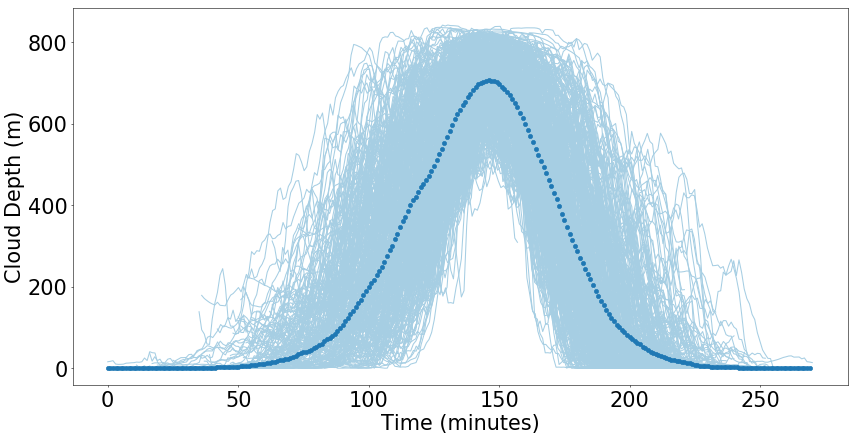

842.3310165405273 270


In [44]:
All_clouds = []
for kk in range(len(XYT)):
    x,y,t1,t2,tmid = XYT[kk,:]
    All_clouds.append(H_all[t1:t2,x,y])
    
longest_cloud = np.max(XYT[:,4]-XYT[:,2])+np.max(XYT[:,3]-XYT[:,4])
mid_cloud = np.max(XYT[:,4]-XYT[:,2])
y_extended = np.zeros((longest_cloud,len(XYT)))
for kk in range(len(XYT)):
    x,y,t1,t2,tmid = XYT[kk,:]

    y_extended[mid_cloud-(tmid-t1):mid_cloud,kk]=H_all[t1:tmid,x,y]
    y_extended[mid_cloud:mid_cloud+(t2-tmid),kk]=H_all[tmid:t2,x,y]
    plt.plot(np.linspace((mid_cloud-(tmid-t1)),(mid_cloud+t2-tmid),t2-t1),y_extended[mid_cloud-(tmid-t1):mid_cloud+t2-tmid,kk],color=Colors['LES_err'])
plt.plot(np.arange(longest_cloud ),np.mean(y_extended,axis=1),'o',color = Colors['LES'])
plt.xlabel('Time (minutes)')
plt.ylabel('Cloud Depth (m)')
if Save_Figures:
    plt.savefig('%s%s_cloud_cycles'%(save_path,file_ID),transparent=True)
plt.show()
print(np.max(y_extended),len(y_extended))

if Save_Files:
    fileCloudH = open('./Pickled_Clouds/%s_mean'%(file_ID),'wb')
    pickle.dump(np.mean(y_extended,axis=1),fileCloudH)
    fileCloudH.close()
    
    fileCloudH = open('./Pickled_Clouds/%s_XYT'%(file_ID),'wb')
    pickle.dump([y_extended,XYT],fileCloudH)
    fileCloudH.close()

# Cov with uniform inflation

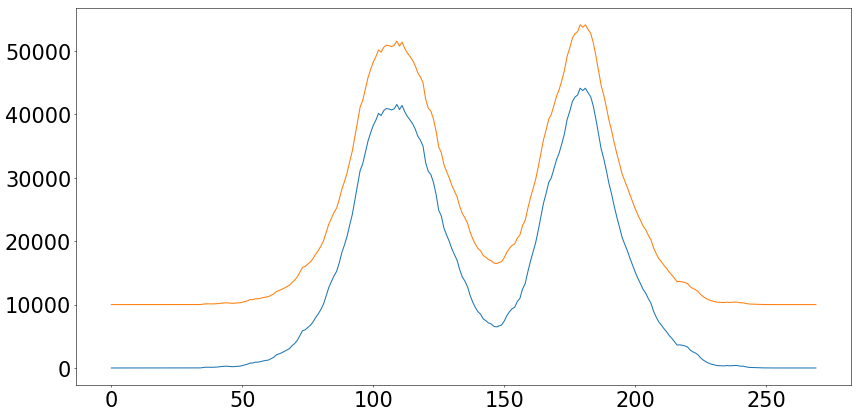

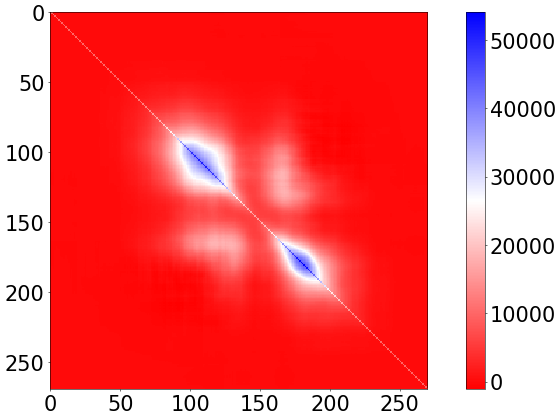

In [45]:
Cov = np.cov(y_extended)

CCov = (Cov+1E4*np.identity(len(Cov)))
plt.plot(np.diag(Cov))
plt.plot(np.diag(CCov))
plt.show()

tmp = np.abs(Cov).max()
plt.imshow(CCov,cmap = 'bwr_r')#,vmin=-tmp,vmax=tmp)
plt.colorbar()
plt.show()

if Save_Files:
    fileCloudH = open('./Pickled_Clouds/%s_mean'%(file_ID),'wb')
    pickle.dump(np.mean(y_extended,axis=1),fileCloudH)
    fileCloudH.close()

    fileCloudH = open('./Pickled_Clouds/%s_cov'%(file_ID),'wb')
    pickle.dump(CCov,fileCloudH)
    fileCloudH.close()